7.367395263436821


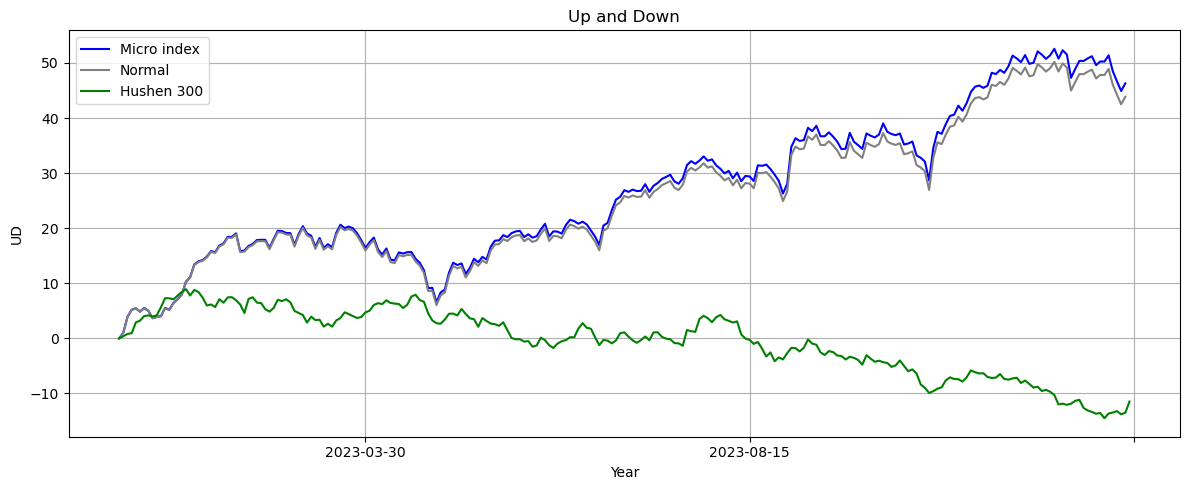

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator


class Micro_index:
    def __init__(self, path1, path2, Date_begin, Date_finish):
        """
        classmethod, staticmethod，
        type, object互相调用issubclass和isinstance
        assert
        """
        self.df = pd.read_csv(path1, index_col=['day', 'id'])
        self.df1 = pd.read_excel(path2, index_col=0)
        self.Date_begin = Date_begin
        self.Date_finish = Date_finish

    def min_400_stock(self):
        """
        本函数用于找到每日市值最低的400只股票，要剔除新上市的股票(tradable)、ST和*ST以及退市整理股(sign)。
        :return: 每日市值最低的400只股票组成的Dataframe
        """
        min_400_stocks_series = pd.Series(dtype=object)
        # 筛选出非0市值的数据，同时sign和tradable为1.0的数据，并按日期进行分组
        sign_1_nonzero = self.df[
            (self.df['value'] != 0) & (self.df['sign'] == 1.0) & (self.df['tradable'] == 1.0)].groupby(level=0)
        for date, group in sign_1_nonzero:
            min_400 = group.nsmallest(400, 'value').index.get_level_values('id').tolist()
            min_400_stocks_series[date] = min_400

        min_400_df = pd.DataFrame(min_400_stocks_series)
        min_400_df.index = pd.to_datetime(min_400_df.index)
        min_400_df.sort_index(ascending=True, inplace=True)
        min_400_df.index = min_400_df.index.strftime('%Y-%m-%d')
        min_400_df.columns = ['stock']

        return min_400_df

    def draw(self, df):
        """
        该函数用于计算市值最小的400只股票的总涨跌幅，并计算指数
        :param df: 市值最小的400只股票的Dataframe：min_400_df
        :return: 指数曲线Dataframe：df_pic
        """
        # 创建两个矩阵计算成分股的涨跌幅，一个矩阵是成分股矩阵，如果是成分股则值为1；另一个是股票涨跌幅矩阵
        df_component = df.explode('stock')
        df_component['dum'] = 1
        _res = df_component.reset_index().pivot(index='index', columns='stock', values='dum').fillna(
            0)  # 拿到成分股的df，如果是成分股，df对应行和列的值为1，其余则为0
        _res1 = self.df.loc[:, 'ud'].unstack()[_res.columns]  # 拿到涨跌幅的df
        matrix1 = _res.values  # 计算成分股矩阵
        matrix2 = _res1.values  # 计算涨跌幅矩阵
        matrix = np.multiply(matrix1, matrix2)
        matrix = np.round(matrix, decimals=2)

        # 计算指数，基点是1000
        index = 1000
        df_pic = pd.DataFrame(columns=['day', 'index'])
        # 对于每一个交易日，从中根据市值选出后400的股票并作等权计算
        for i in range(df.index.get_loc(self.Date_begin), df.index.get_loc(self.Date_finish)):
            total_ud = 0  # 涨跌幅
            stock_day = df.index[i]
            total_ud += np.sum(matrix[i])
            if i == df.index.get_loc(self.Date_begin):
                index = index
            else:
                index = index * (1 + total_ud / 40000)
            df_pic.loc[len(df_pic)] = [str(stock_day), index]
        return df_pic

    def Simulated_trading_closing_adjustment(self, df, df2):
        """
        由于交易存在手续费，需要剔除每日更新成分股以及等权分配买卖带来的印花税以及手续费
        这里采用开盘调仓
        :param df: 指数曲线Dataframe：df_pic
        :param df2: 市值最小的400只股票的Dataframe：min_400_df
        :return: 扣除手续费后的Dataframe：merge
        """
        # 计算理想状态下的累计涨跌幅和每日涨跌幅
        reference_price = df[df['day'] == self.Date_begin]['index'].values[0]
        df['total_ud'] = (df['index'] - reference_price) / reference_price * 100
        df['day_ud'] = df['index'].pct_change() * 100
        df = df.fillna(0).set_index('day')
        df.index.name = None
        merge = pd.merge(df, df2, left_index=True, right_index=True, how='left')

        # 创建money列并设置第一行的值
        merge['money'] = 0.0
        merge.at[merge.index[0], 'money'] = 400000000
        a = 0 # 总换手率
        # 计算money列从第二行开始的值
        for i in range(1, len(merge) - 1):
#         for i in range(1, 6):
            fee = 0
            total_ud = 0
            total_ud1 = 0
            transaction_amount = 0  #每天换手率
            pre_assets = merge.loc[merge.index[i - 1], 'money'] / 400  # 算上涨跌幅并扣除调仓费用后，等权每只股票分到的金额
            # 计算不同的股票数量
            today_stock = set(merge.at[merge.index[i], 'stock'])  # 今日成分股
            tomorrow_stock = set(merge.at[merge.index[i + 1], 'stock'])  # 明日成分股
            today_delete = today_stock - tomorrow_stock  # 今日成分股剔除的股票
            tomorrow_add = tomorrow_stock - today_stock  # 明日成分股加入的股票
            different_stocks_number = len(today_stock.symmetric_difference(tomorrow_stock)) / 2  # 不同股票的数量
        #     print(previous_stock)
            for stock in today_stock:
                # 锁定日期：print(merge.index[i])，锁定股票：print(stock)
                # 两种算法计算涨跌幅，一个是利用每只股票的涨跌幅和求涨跌幅
                ud = self.df.loc[merge.index[i], stock][5] / 100
                total_ud1 += ud / 400  # 取涨跌幅所占的权重，400只股票也就是除以400
                
                # 第二个是利用指数的涨跌幅直接拿到作为收益的涨跌幅
                total_ud = merge.loc[merge.index[i], 'day_ud'] / 100
            for stock in today_stock:
                ud = self.df.loc[merge.index[i], stock][5] / 100
                if stock in today_delete:
                    fee += pre_assets * (1 + ud) * 0.002  # 如果是剔除的股票，则计算卖出手续费
                    transaction_amount = pre_assets * (1 + ud)
                else:
                    # 昨日每只股票到今天的最终价格减去今天的等权金额
                    # 如果是正数，说明说赚钱了应该减仓；如果是负数，说明亏钱了，应该加仓
                    assets = pre_assets * (1 + total_ud)
                    number = pre_assets * (1 + ud) - assets
                    if number > 0:
                        fee += number * 0.002  # 涨的股票应该卖出
                        transaction_amount +=  number
                    elif number < 0:
                        fee += abs(number * 0.001)  # 跌的股票应该买入
                        transaction_amount +=  abs(number)

            # 计算手续费
            fee += different_stocks_number * 0.001 * assets  # 加入的成分股买入手续费
            transaction_amount += different_stocks_number * assets
            # 参考每日涨跌幅计算money
            #             ud_per_day = merge.at[merge.index[i], 'day_ud'] / 100
            #             previous_money = merge.at[merge.index[i - 1], 'money']
            merge.at[merge.index[i], 'money'] = pre_assets * 400 * (1 + total_ud) - fee
            a += transaction_amount
        # 计算除去手续费的累计涨跌幅和每日涨跌幅
        reference_price = merge[merge.index == self.Date_begin]['money'].values[0]
        merge['total_income_ud'] = (merge['money'] - reference_price) / reference_price * 100

        merge['day_income_ud'] = merge['money'].pct_change() * 100
        merge = merge.fillna(0)
        merge.index.name = None
        
        merge = merge.drop(merge.index[-1])
        ava = merge['money'].sum() / len(merge)
        print(a / ava)
        return merge

    def Simulated_trading_opening_adjustment(self, df, df2):
        """
        由于交易存在手续费，需要剔除每日更新成分股以及等权分配买卖带来的印花税以及手续费
        这里采用开盘调仓
        :param df: 指数曲线Dataframe：df_pic
        :param df2: 市值最小的400只股票的Dataframe：min_400_df
        :return: 扣除手续费后的Dataframe：merge
        """
        # 计算理想状态下的累计涨跌幅和每日涨跌幅
        reference_price = df[df['day'] == self.Date_begin]['index'].values[0]
        df['total_ud'] = (df['index'] - reference_price) / reference_price * 100
        df['day_ud'] = df['index'].pct_change() * 100
        df = df.fillna(0).set_index('day')
        df.index.name = None
        merge = pd.merge(df, df2, left_index=True, right_index=True, how='left')

        merge['money'] = 0.0
        merge.at[merge.index[0], 'money'] = 400000000

        # 计算money列从第二行开始的值
        for i in range(1, len(merge)):
            fee = 0
            total_ud = 0
            rebalence_ud = 0
            pre_assets = merge.loc[merge.index[i - 1], 'money'] / 400  # 昨日等权每只股票分到的金额
            # 计算不同的股票数量
            previous_stock = set(merge.at[merge.index[i - 1], 'stock'])  # 昨日成分股
            current_stock = set(merge.at[merge.index[i], 'stock'])  # 今日成分股
            previous_delete = previous_stock - current_stock  # 昨日有的股票，也就是今日成分股剔除的股票
            current_delete = current_stock - previous_stock  # 今日有的股票，也就是今日成分股加入的股票
            different_stocks_number = len(current_stock.symmetric_difference(previous_stock)) / 2  # 不同股票的数量
            for stock in previous_stock:
                # 锁定日期：print(merge.index[i])，锁定股票：print(stock)
                pre_open = self.df.loc[merge.index[i], stock][2]  # 昨日开盘价
                today_open = self.df.loc[merge.index[i], stock][3]  # 今日开盘价
                pre_close =  self.df.loc[merge.index[i], stock][0]  # 今日开盘价
                ud = (today_open - pre_open) / pre_open  # 计算昨天购买时到今天卖出时总共的涨跌幅
                ud2 = (pre_close - pre_open) / pre_open  # 开盘买，收盘做rebalance，计算一天的涨跌幅
                total_ud += ud / 400
                rebalence_ud += ud2 / 400
            for stock in previous_stock:
                pre_open = self.df.loc[merge.index[i], stock][2]  # 昨日开盘价
                today_open = self.df.loc[merge.index[i], stock][3]  # 今日开盘价
                pre_close =  self.df.loc[merge.index[i], stock][0]  # 今日开盘价
                ud = (today_open - pre_open) / pre_open  # 计算昨天购买时到今天卖出时总共的涨跌幅
                assets = pre_assets * (1 + rebalence_ud)
                if stock in previous_delete:
                    fee += pre_assets * (1 + ud) * 0.002  # 如果是剔除的股票，则计算卖出手续费
                else:
                    # 昨日每只股票到今天的最终价格减去今天的等权金额
                    # 如果是正数，说明说赚钱了应该减仓；如果是负数，说明亏钱了，应该加仓
                    number = pre_assets * (1 + ud) - assets
                    if number > 0:
                        fee += number * 0.002  # 涨的股票应该卖出
                    elif number < 0:
                        fee += abs(number * 0.001)  # 跌的股票应该买入

            # 计算手续费
            fee += different_stocks_number * 0.001 * assets  # 加入的成分股买入手续费

            # 通过总共的资金减去调仓以及剔除加入成分股的手续费
            merge.at[merge.index[i], 'money'] = pre_assets * 400 * (1 + total_ud) - fee  # 开盘调仓完扣除手续费剩余的钱，今日手上拿的钱

        # 计算除去手续费的累计涨跌幅和每日涨跌幅
        reference_price = merge[merge.index == self.Date_begin]['money'].values[0]
        merge['total_income_ud'] = (merge['money'] - reference_price) / reference_price * 100

        merge['day_income_ud'] = merge['money'].pct_change() * 100
        merge = merge.fillna(0)
        merge.index.name = None
        
        merge['day_income_ud'] = merge['day_income_ud'].shift(-1)
        merge = merge.dropna()
        print(merge)
        return merge

    def plot_up_and_down(self, merge, df_300):
        plt.figure(figsize=(12, 5))
        plt.plot(merge.index, merge['total_ud'], linestyle='-', color='blue', label='Micro index')
        plt.plot(merge.index, merge['total_income_ud'], linestyle='-', color='grey', label='Normal')
        plt.plot(df_300.index, df_300['total_ud_now'], linestyle='-', color='green', label='Hushen 300')

        months = MonthLocator(interval=3)
        plt.gca().xaxis.set_major_locator(months)

        plt.title('Up and Down')
        plt.xlabel('Year')
        plt.ylabel('UD')
        plt.grid(True)
        plt.tight_layout()
        plt.legend()

        plt.show()

    def plot_monthly_excess(self, merge, df_300):
        """
        计算月度超额
        :param merge: merge中包含了指数的理想状态下的累计涨跌幅和除去手续费后的累计涨跌幅
        :param df_300: 沪深300的累计涨跌幅
        :return: 图像
        """
        df_300.index = pd.to_datetime(df_300.index)
        merge.index = pd.to_datetime(merge.index)

        # 以月为单位进行累加
        monthly_ud = merge['day_ud'].resample('M').sum()
        monthly_income = merge['day_income_ud'].resample('M').sum()
        monthly_ud_300 = df_300['day_ud_now'].resample('M').sum()

        plt.figure(figsize=(12, 5))
        # plt.plot(monthly_ud.index, monthly_ud, linestyle='-', color='blue', label='Micro index Excess')
        # plt.bar(monthly_income.index, monthly_income, linestyle='-', color='grey', label='Normal Excess')
        # plt.bar(monthly_ud_300.index, monthly_ud_300, linestyle='-', color='green', label='Hushen 300 Excess')

        # 计算月度超额并绘制条状图
        plt.bar(monthly_income.index, monthly_income - monthly_ud_300, color='grey', label='Normal Excess', width=20)

        months = MonthLocator(interval=2)
        plt.gca().xaxis.set_major_locator(months)
        plt.title('Monthly Excess Up and Down')
        plt.xlabel('Year')
        plt.ylabel('Excess UD')
        plt.grid(True)
        plt.tight_layout()
        plt.legend()

        plt.show()
        
    def paper_trading(self):
        merge['money'] = 0.0
        merge['money_real'] = 0.0
        merge.at[merge.index[0], 'money_real'] = 400000000
        # merge.at[merge.index[0], 'money'] = 400000000

        for i in range(0, len(merge)):
            if i == 0:
                buy_stock = set(merge.at[merge.index[i + 1], 'stock'])  # 第一天进入，根据收盘价筛选购买400只股票
                money = merge.loc[merge.index[i], 'money_real']
                fee = money * 0.001
                merge.at[merge.index[i + 1], 'money_real'] = money - fee  # 记录下一天手上的实际资金
        #         merge.at[merge.index[i + 1], 'money'] = money 
        # for i in range(1, 6):
            elif i > 0 and i < len(merge)-1:
                fee = 0
                total_ud = 0
                total_ud1 = 0
                pre_assets = merge.loc[merge.index[i], 'money_real'] / 400  # 算上涨跌幅并扣除调仓费用后，等权每只股票分到的金额
                # 计算不同的股票数量
                today_stock = set(merge.at[merge.index[i], 'stock'])  # 今日成分股
                tomorrow_stock = set(merge.at[merge.index[i + 1], 'stock'])  # 明日成分股
                today_delete = today_stock - tomorrow_stock  # 今日成分股剔除的股票
                tomorrow_add = tomorrow_stock - today_stock  # 明日成分股加入的股票
                different_stocks_number = len(today_stock.symmetric_difference(tomorrow_stock)) / 2  # 不同股票的数量
            #     print(previous_stock)
                for stock in today_stock:
                    # 锁定日期：print(merge.index[i])，锁定股票：print(stock)
                    # 两种算法计算涨跌幅，一个是利用每只股票的涨跌幅和求涨跌幅
                    # ud = merge_df.loc[merge.index[i], stock][5] / 100
                    # total_ud1 += ud / 400  # 取涨跌幅所占的权重，400只股票也就是除以400
                    # 第二个是利用指数的涨跌幅直接拿到作为收益的涨跌幅
                    total_ud = merge.loc[merge.index[i], 'day_ud'] / 100
                for stock in today_stock:
                    ud = merge_df.loc[merge.index[i], stock][5] / 100
                    if stock in today_delete:
                        fee += pre_assets * (1 + ud) * 0.001  # 如果是剔除的股票，则计算卖出手续费
                    else:
                        # 昨日每只股票到今天的最终价格减去今天的等权金额
                        # 如果是正数，说明说赚钱了应该减仓；如果是负数，说明亏钱了，应该加仓
                        assets = pre_assets * (1 + total_ud)
                        number = pre_assets * (1 + ud) - assets
        #                 print(number)
                        if number > 0:
                            fee += number * 0.002  # 涨的股票应该卖出
                        elif number < 0:
                            fee += abs(number * 0.001)  # 跌的股票应该买入

                # 计算手续费
                fee += different_stocks_number * 0.001 * assets  # 加入的成分股买入手续费
                # 参考每日涨跌幅计算money
                #             ud_per_day = merge.at[merge.index[i], 'day_ud'] / 100
                #             previous_money = merge.at[merge.index[i - 1], 'money']
                merge.at[merge.index[i + 1], 'money_real'] = pre_assets * 400 * (1 + total_ud) - fee
        #         merge.at[merge.index[i + 1], 'money'] = pre_assets * 400 * (1 + total_ud)

            elif i == len(merge) -1:
                money = merge.loc[merge.index[i], 'money_real']
                today_stock = set(merge.at[merge.index[i], 'stock'])  # 今日成分股
                total_ud = merge.loc[merge.index[i], 'day_ud'] / 100
                fee = money * (1 + total_ud) * 0.002
                final_money = money * (1 + total_ud) - fee
                merge.at[merge.index[i], 'money_real'] = pre_assets * 400 * (1 + total_ud) - fee    
        #         merge.at[merge.index[i], 'money'] = pre_assets * 400 * (1 + total_ud)   

    def CSI300(self):
        df_300 = self.df1.iloc[:, [3, 5, 7]]
        df_300.columns = ['index', 'day_ud_original', 'day_ud_original']
        df_300 = df_300.sort_index()
        df_300 = df_300[(df_300.index >= self.Date_begin) & (df_300.index < self.Date_finish)]

        reference_price = df_300[df_300.index == self.Date_begin]['index'].values[0]
        df_300['total_ud_now'] = (df_300['index'] - reference_price) / reference_price * 100

        df_300['day_ud_now'] = df_300['index'].pct_change() * 100
        df_300 = df_300.fillna(0)
        df_300.index.name = None

        return df_300

    def main_process(self):
        """
        比较收盘调仓和开盘调仓的情况，发现结果差不多，但是在指数编制上更多的采取开盘调仓
        但是指数的涨跌幅以及指数是针对收盘价时来判断的
        :return:
        """
#         收盘调仓
        min_400_df = self.min_400_stock()
        df_pic = self.draw(min_400_df)
        merge = self.Simulated_trading_closing_adjustment(df_pic, min_400_df)
        df_300 = self.CSI300()
        self.plot_up_and_down(merge, df_300)
#         self.plot_monthly_excess(merge, df_300)


        # 开盘调仓
#         min_400_df = self.min_400_stock()
#         df_pic = self.draw(min_400_df)
#         merge1 = self.Simulated_trading_opening_adjustment(df_pic, min_400_df)
#         df_300 = self.CSI300()
#         self.plot_up_and_down(merge1, df_300)
#         self.plot_monthly_excess(merge1, df_300)

stock_analysis = Micro_index('处理过的全量数据.csv', '沪深300全量数据.xlsx', '2022-12-29', '2023-12-29')  # 熊市
stock_analysis.main_process()

# 2014.3.12-2015.7.1

11.239695815646085


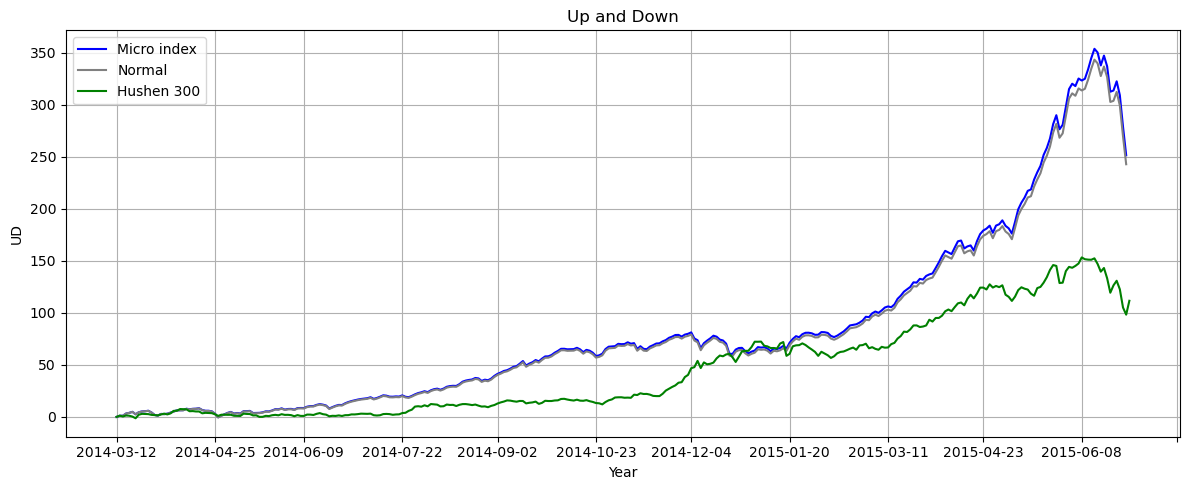

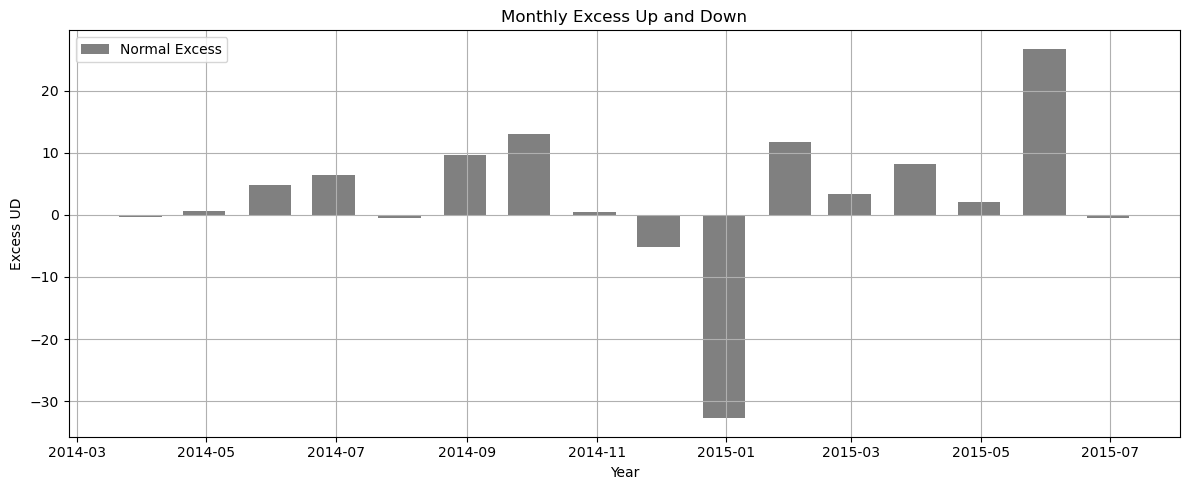

In [7]:
stock_analysis = Micro_index('处理过的全量数据.csv', '沪深300全量数据.xlsx', '2014-03-12', '2015-07-01')  # 牛市
stock_analysis.main_process()

# 2015.6.1-2016.6.30

10.900150941191653


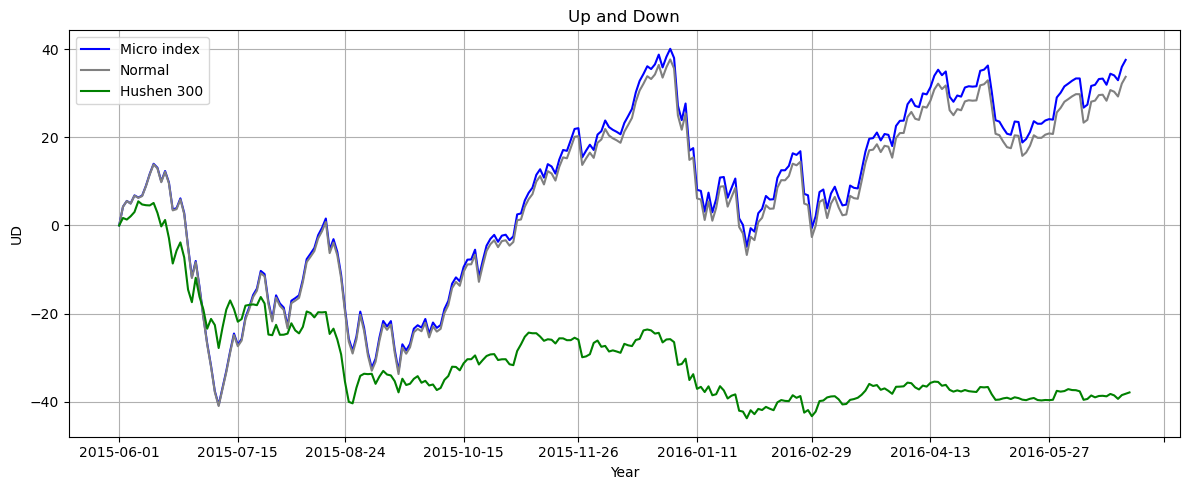

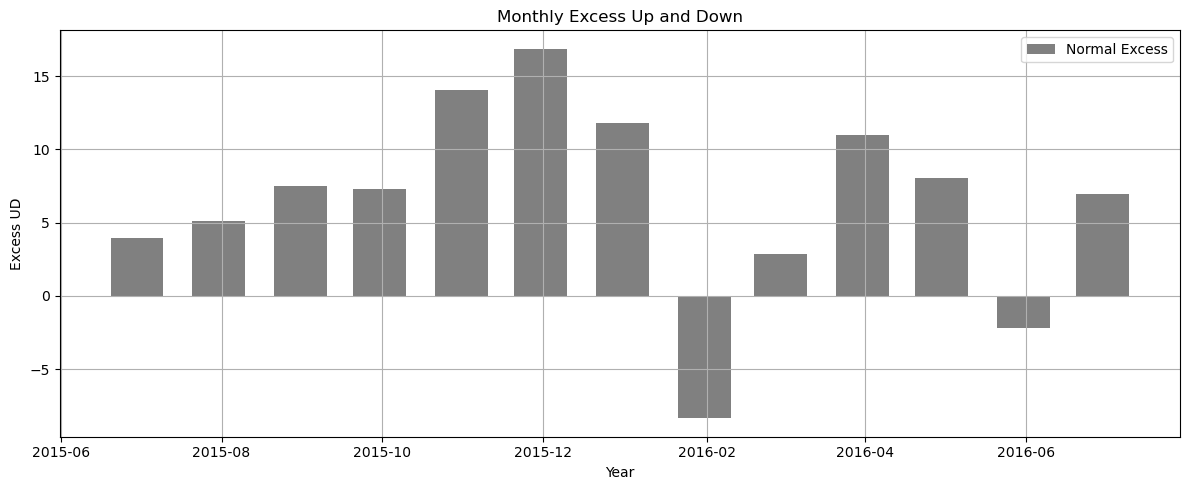

In [8]:
stock_analysis = Micro_index('处理过的全量数据.csv','沪深300全量数据.xlsx', '2015-06-01', '2016-06-30')  # 熊市
stock_analysis.main_process()

4.1857665312544325


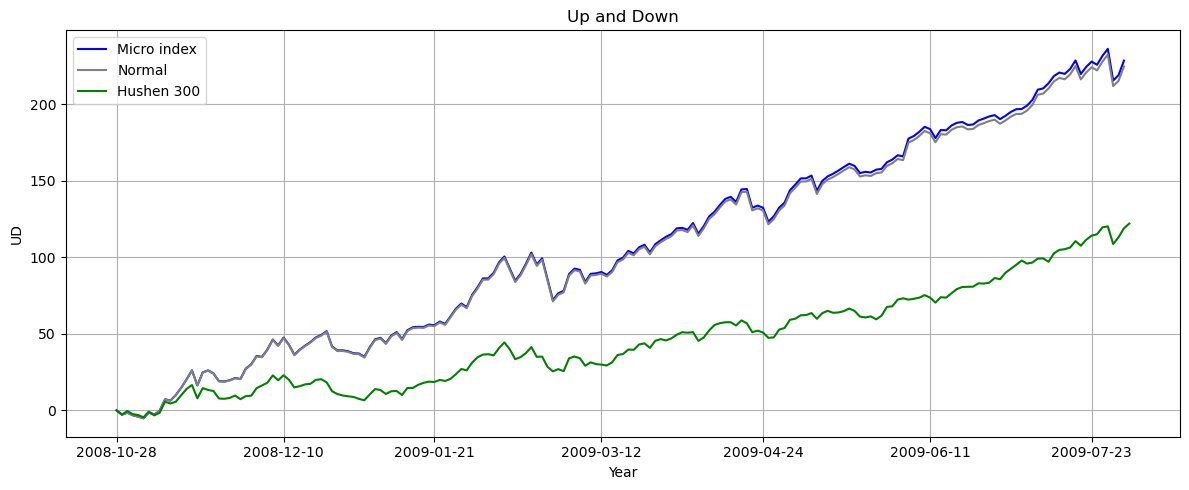

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (10,) and arg 1 with shape (11,).

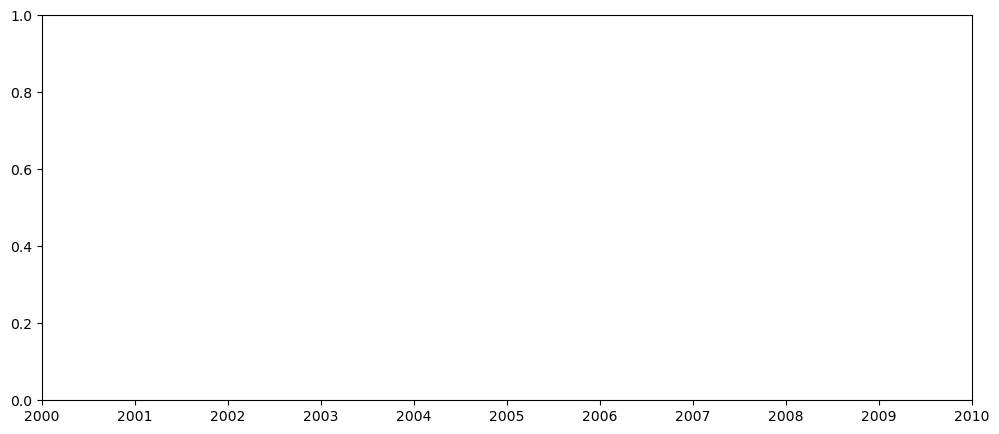

In [9]:
stock_analysis = Micro_index('处理过的全量数据.csv', '沪深300全量数据.xlsx', '2008-10-28', '2009-08-04')  # 牛市
stock_analysis.main_process()

18.199583299983157


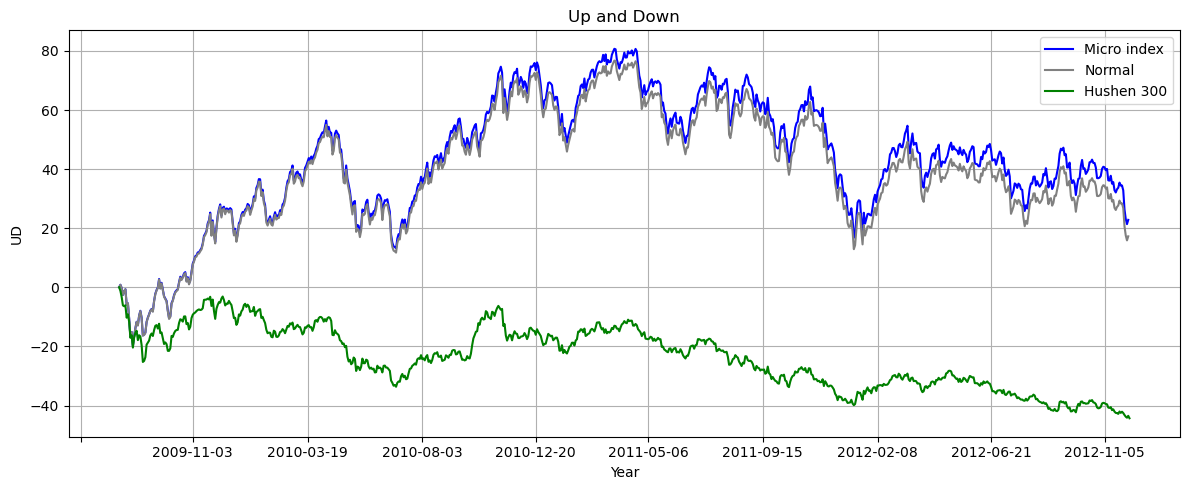

In [12]:
stock_analysis = Micro_index('处理过的全量数据.csv', '沪深300全量数据.xlsx', '2009-08-04', '2012-12-04')  # 熊市
stock_analysis.main_process()

13.08569514599646


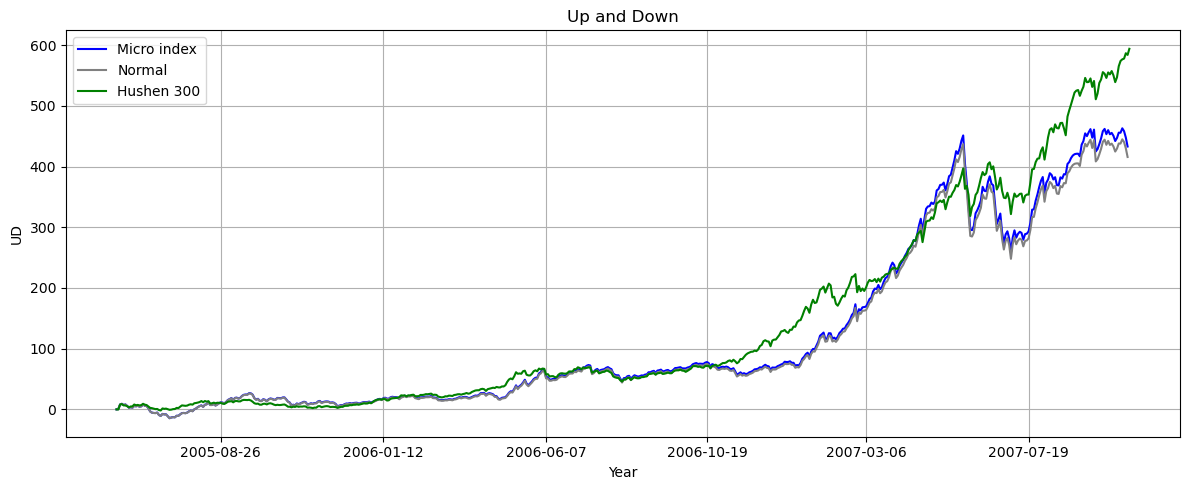

In [13]:
stock_analysis = Micro_index('处理过的全量数据.csv', '沪深300全量数据.xlsx', '2005-06-06', '2007-10-16')  # 牛市
stock_analysis.main_process()

5.559044407465126


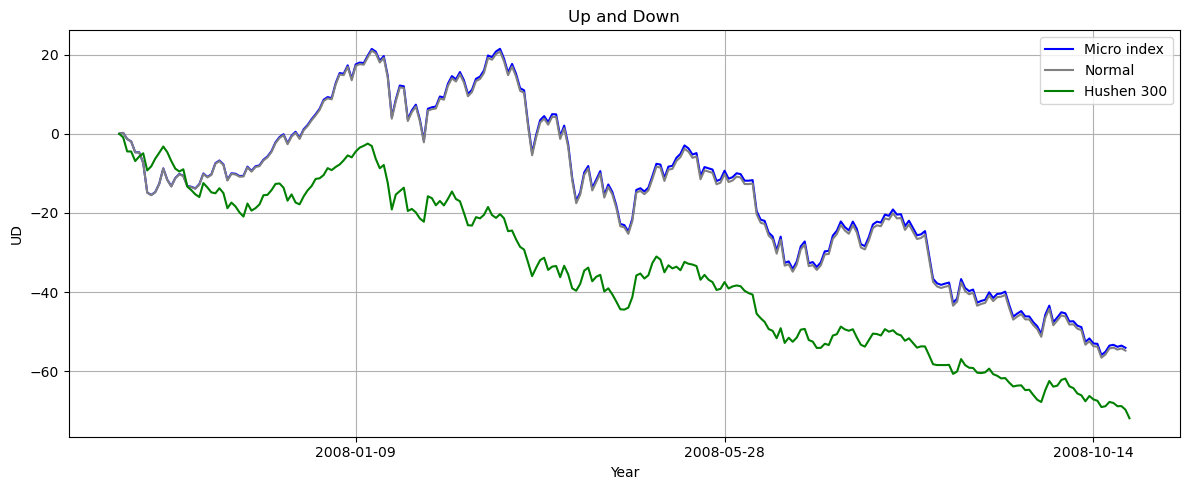

In [14]:
stock_analysis = Micro_index('处理过的全量数据.csv', '沪深300全量数据.xlsx', '2007-10-16', '2008-10-28')  # 熊市
stock_analysis.main_process()

In [95]:
pig = object
林欣妤 = type(1.031)

In [93]:
issubclass(林欣妤, pig)

True